# Initial Setup

This notebook presents the construction and demonstration of a recommender system, conceptu- alized within the framework of the AI-Informed Analytics Cycle. The system is engineered to address a significant query pertaining to consumer behavior and product interaction on the Amazon platform

## Imports

In [24]:
import numpy as np
import pandas as pd 
import os
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise import BaselineOnly, SVD, KNNBaseline
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.accuracy import rmse, mae
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate, KFold
from surprise.model_selection import GridSearchCV
from collections import defaultdict

## Data Preprocessing

Before beginning to work on the recommender system it is important to preprocess the data so that we can increase computational efficiency. Initially the timestamp column was being considered but it was later dropped since there was no purpose. Headers for electronic item ratings from amazon are as follows:

- **uid:** User ID for the reviewer
- **pid:** Product ID of the product being reviewed
- **rating:** Rating for the product from 1.0 to 5.0

In [27]:
# Read the data
df = pd.read_csv("electronic_ratings.csv",names=['uid','pid','rating','time'])

# Drop timestamp column because useless
df.drop(['time'], axis=1,inplace=True)

# Convert data types to reduce memory usage
df['rating'] = df['rating'].astype('int8')  
df['uid'] = df['uid'].astype('string')
df['pid'] = df['pid'].astype('string')

# Check if dataset has null values to omit
assert df.isnull().sum().sum() == 0, "Null values exist"
print("No null values")

No null values


Our dataset inspection reveals an absence of null values, indicating a clean data set ready for further processing. Consequently, we proceed to refine our dataset to an optimal size for model training. Specifically, we will focus on ratings associated with products that have garnered at least 25 ratings. This selection criterion is crucial for our collaborative filtering-based recommender system. By emphasizing data from frequently rated products, we aim to enhance the reliability and accuracy of our item-item recommendations, ensuring that our model is trained on credible and meaningful interactions

In [17]:
# Separate dataset
over25_df=df.groupby("pid").filter(lambda x:x['rating'].count() >=25)
over25_df = over25_df.reset_index(drop=True)

# Design Choices

Before constructing our recommender system, a thorough analysis of our dataset is required due to its vast size. Performing **cross-validation** for every possible factor combination is impractical due to the number of factors involved. Therefore we use **data visualization** and **key metric computations** to guide our preliminary design choices mentioned below

- If taking the **Memory-Based** approach should an **Item-Item** or **User-Item** based **Collaborative Filter (CF)** be used?
- What **recommendation algorithms** should be used given the range of choices provided from matrix factorization techniques like **SVD** to various **KNN** implementations, alongside baseline models for performance benchmarks?
- What should the value of parameters within the decided algorithms be, such as the number of neighbors ('k') for KNN methods, which significantly influence recommendation quality?

This section details the design choices for the recommender system, providing the rationale for each decision based on data insights and recognized recommendation system methodologies, ensuring that the approach is logically grounded and transparent

## Visualization and Analysis of Ratings Distribution

First step in the visualization process would be to understand the distribution of ratings, as well as the number of ratings per user and per item. This information will help decide which recommendation algorithm to use along with the type of collaborative filtering to use when using memory-based algorithms


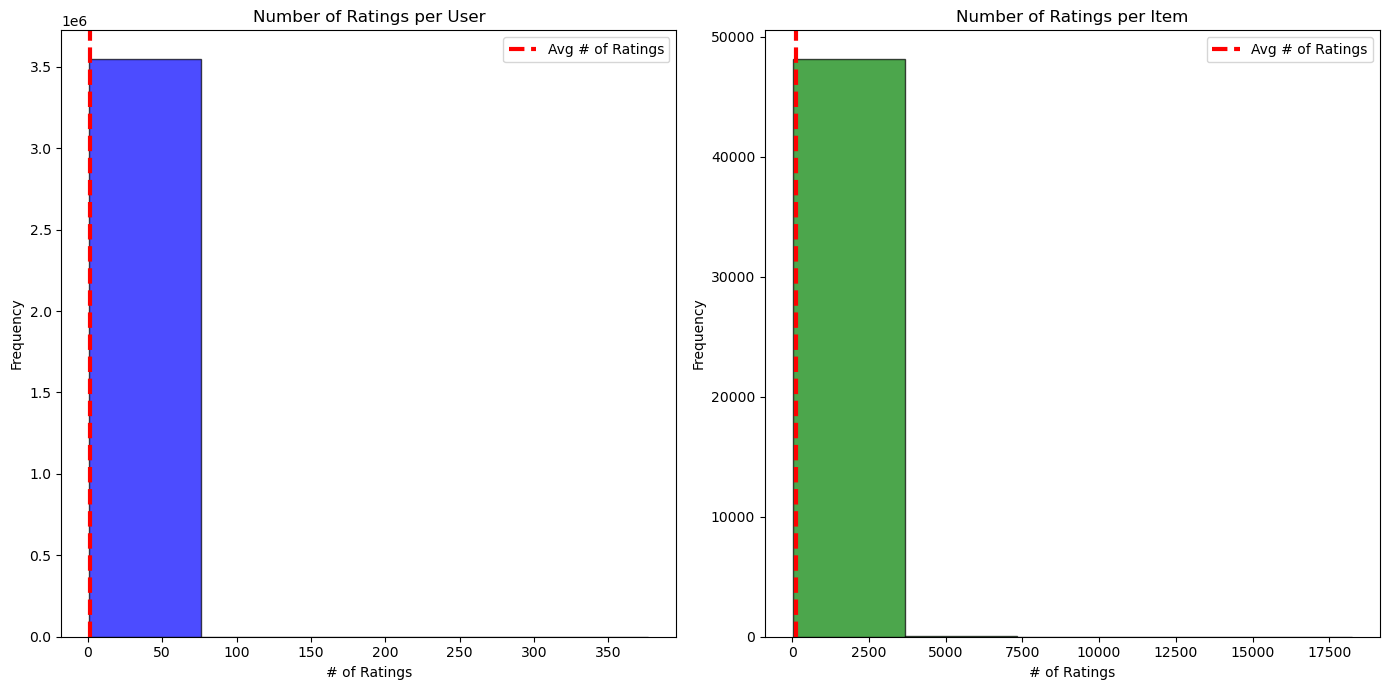

Average number of ratings per user: 1.728759375072246
Average number of ratings per item: 127.28332710590774


In [5]:
# Total number of ratings by user and by item
user_ratings = over25_df.groupby('uid').size()
item_ratings = over25_df.groupby('pid').size()

# Plot
plt.figure(figsize=(14, 7))

# Subplot - # ratings per user
plt.subplot(1, 2, 1)
plt.hist(user_ratings, bins=5, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(user_ratings.mean(), color='red', linestyle='dashed', linewidth=3)
plt.title('Number of Ratings per User')
plt.xlabel('# of Ratings')
plt.ylabel('Frequency')
plt.legend(['Avg # of Ratings'])

# Subplot - # ratings per item
plt.subplot(1, 2, 2)
plt.hist(item_ratings, bins=5, alpha=0.7, color='green', edgecolor='black')
plt.axvline(item_ratings.mean(), color='red', linestyle='dashed', linewidth=3)
plt.title('Number of Ratings per Item')
plt.xlabel('# of Ratings')
plt.ylabel('Frequency')
plt.legend(['Avg # of Ratings'])

plt.tight_layout()
plt.show()

# Print averages of both plots
print("Average number of ratings per user: " +str(user_ratings.mean()))
print("Average number of ratings per item: " +str(item_ratings.mean()))

We can observe the following things by looking at the histograms above

**Left: Number of Ratings per User** 
- Right-skewed histogram indicating that majority of users provide a low number of ratings
- Average number of ratings per user is approximately 1.73, indicating that average is not representative of the majority due to the presence of outliers (users with a very high number of ratings)
- This suggests a few very active users and many users with fewer ratings, which could potentially lead to a model biased towards the preferences of more active users if not properly accounted for

**Right: Number of Ratings per User** 
- Right-skewed histogram indicating that majority of items receive a low number of ratings with few outliers
- Average number of ratings per item is approximately 127.83, indicating that items, on average, are rated by more users than users rate items

Observed plots suggest that there are popular items that attract the majority of ratings, which dominate the recommendation process

## Justification of Algorithms Selected for Preliminary Evaluation

Given the observed data distribution, the following three algorithms are selected for preliminary evaluation of the recommender system:

1. **BaselineOnly**: Given the wide variance in user activity and item popularity, baseline estimates can help normalize for users who may rate more harshly or generously and items that may be predisposed to higher or lower ratings. This algorithm accounts for the baseline user and item biases observed above.

2. **SVD (Singular Value Decomposition)**: Effective at capturing latent factors and dealing with sparse data. Skewness in above plots suggests matrix factorization may uncover underlying pattern not apparent from current visualization of raw rating counts.

3. **KNNBaseline (Item - Item)**: Combines collaborative filtering with baseline adjustments. Well-suited since similarity between users or items is considered while adjusting for mean rating levels. The baseline aspect of KNNBaseline is important given the variance in rating behaviors and item reception, as indicated by the plots.


Since popular items dominate the recommendation process we will use **Item-Item** collaborative filtering rather than **User-Item** filtering for the memory-based KNN approach. This method is better suited for our dataset because it focuses on the popular items that already have many ratings, leading to more accurate recommendations. On the other hand, user-based filtering would struggle due to sparse data, as most users rate only a few items. Our goal is to recommend items similar to those that are popular, taking advantage of the dataset's popularity bias.




# Preliminary evaluation 
With these algorithms selected, the next step is to perform a preliminary evaluation on a representative subset of the data. This evaluation will focus on RMSE or MAE. It is important to test algorithmic performance on a subset of data first before applying it to the larger dataset because algorithms like KNN which compare similarity with every node take too much time and compute power. Therefore we take a subset of the data and evaluate algorithm performance 

## Model Comparison
Now we will compare how our selected models perform on the subset. Please note that using **Mean Squared Difference** similarity measure and a **minimum support value of k = 5** is taken for the KNNBaseline algorithm because of the computational and time efficiency witnessed during development of this project. All other similarity metrics were too computationaly complex to be realistically completed

In [28]:
# Create the subset df
subset_df = over25_df.sample(frac=0.1, random_state=0)

# Load df in surprise
reader = Reader(rating_scale=(1, 5))
sub_data = Dataset.load_from_df(subset_df, reader)

# Configure KNN options
sim_options = {
    'name': 'msd',
    'user_based': False,
    'min_support': 5      
}

# Define algorithms to use
algorithms = {
    'BaselineOnly': BaselineOnly(),
    'SVD': SVD(),
    'KNNBaseline': KNNBaseline(sim_options=sim_options)
}

# Split training and testing data taking 30% for testing and 70% for training
train_df, test_df = train_test_split(sub_data, test_size=0.3, random_state=0)

# Loop through all the algorithms
for name, algo in algorithms.items():
    
    # Print algo name
    print(f'\nRunning {name}')
    
    # Start timing runtime
    start_time = time.time() 
    
    # Train algorithm and make predictions then calculate time taken
    algo.fit(train_df)        
    predictions = algo.test(test_df)
    end_time = time.time()    
    time_taken = end_time - start_time 
    
    # Print RMSE, MAE and Time Taken for every algorithm
    rmse_val = rmse(predictions, verbose=False)
    mae_val = mae(predictions, verbose=False)
    print(f"RMSE: {rmse_val:.4f}")
    print(f"MAE: {mae_val:.4f}")
    print(f"Runtime: {time_taken:.2f} seconds")


Running BaselineOnly
Estimating biases using als...
RMSE: 1.3068
MAE: 1.0318
Time: 3.47 seconds

Running SVD
RMSE: 1.3071
MAE: 1.0296
Time: 7.28 seconds

Running KNNBaseline
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.3068
MAE: 1.0318
Time: 28.07 seconds


The analysis of the output reveals that the BaselineOnly, SVD, and KNNBaseline algorithms exhibit nearly identical performance in terms of RMSE and MAE. However, significant differences emerge in their execution times. Given its simplicity, the BaselineOnly model serves as an effective benchmark for evaluating the performance of more complex algorithms. Notably, its RMSE and MAE values surpass 1.0, suggesting that predictions could deviate by an entire rating point. Despite this, our attention now shifts towards optimizing the SVD model for application to the full dataset. The decision to exclude KNNBaseline from further consideration stems from its disproportionately longer runtime relative to SVD, despite yielding similar error metrics. This efficiency disparity renders KNNBaseline impractical for training on the full dataset, as it would significantly prolong the process without offering substantial improvements in accuracy

## SVD Optimization

Now we will optimize our SVD algorithm using **GridSearchCV** with **cross validation**. Note that the values below may seem random but they were assigned after rigorous trial and error and below cross validation is just shown for representation purposes

In [29]:
param_grid = {
    'n_factors': [40,46], 
    'n_epochs': [50,59],  
    'lr_all': [0.002,0.003],  
    'reg_all': [0.21,0.3],  
    'init_mean': [0.03],
    'init_std_dev': [0.06] 
}
# Use 3-fold CV to save time
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
start_time = time.time()
gs.fit(sub_data)
end_time = time.time()


# Print the best RMSE score and corresponding parameters
print(f"Best RMSE: {gs.best_score['rmse']}")
print(f"Best MAE {gs.best_score['mae']}")
print(f"Best Params: {gs.best_params['rmse']}")
print(f"Runtime: {end_time - start_time:.2f} seconds")

Best RMSE: 1.3019684629768478
Best MAE 1.033936955901271
Best Params: {'n_factors': 46, 'n_epochs': 59, 'lr_all': 0.003, 'reg_all': 0.21, 'init_mean': 0.03, 'init_std_dev': 0.06}
Runtime: 687.20 seconds


# Evaluation on Actual Dataset

In [36]:
# Create reader object read data and split again
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df, reader)
train_df, test_df = train_test_split(data, test_size=0.3, random_state=0)

In [10]:
# Create and train the model
best_params_rmse = gs.best_params['rmse']
algo = SVD(**best_params_rmse)

# Train the model
algo.fit(train_df)

# Make predictions on test set
predictions = algo.test(test_df)

# Show RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 1.2831
MAE:  1.0165


After hyperparameter tuning and applying the SVD algorithm to the entire dataset, the recommender system achieved
- **RMSE = 1.2831**
- **MAE = 1.0165**

Its a noticeable improvement in prediction accuracy compared to the initial evaluations conducted on a smaller subset using the initial 3 algorithms. It highlights the importance of hyperparameter tuning in optimizing model performance, particularly in enhancing its predictive accuracy. SVD demonstrated scalability and adaptability by outperforming other algorithms when applied to the entire dataset. This balance between computational efficiency and predictive accuracy, especially after fine-tuning, positions SVD as an optimal choice for the recommender system. The reduction in RMSE and MAE suggests that the model's predictions are closer to actual user ratings, enhancing the likelihood of users receiving more relevant recommendations. Such precision in recommendation systems can significantly improve user satisfaction and engagement across the platform, highlighting the efficacy of the SVD algorithm in capturing complex user-item interaction patterns within large datasets.

# Recommender Demo

## Recommendation Function

This function takes the user list, dataframe of ratings and number of recommendations to generate as input and prints the recommended electronic items along with their ratings. Not only that if the item being recommended has been rated by the user in the past then it will also print the actual rating next to the predicted rating

In [65]:
def generate_recommendations(user_ids, df, n=5):
    assert n <= 10, "Please don't generate more than 10 recommendations for easier visualization"
    
    for user_id in user_ids:
        
        # Get the unique Item IDs
        all_item_ids = df['pid'].unique().tolist()
        
        # Print user ID
        print(f"\nUser: {user_id}")
        
        # Generate predictions using SVM model for all items for this user
        predictions = [algo.predict(user_id, item_id) for item_id in all_item_ids]
        
        # Sort the predictions by estimated rating in descending order and extract top n
        predictions.sort(key=lambda x: x.est, reverse=True)
        top_n_predictions = predictions[:n]
        
        # Go through every prediction
        for prediction in top_n_predictions:
            item_id, estimated_rating = prediction.iid, prediction.est
            actual_rating_row = df[(df['uid'] == user_id) & (df['pid'] == item_id)]
            actual_rating = actual_rating_row['rating'].iloc[0] if not actual_rating_row.empty else None
            
            # Print actual rating if the given user has actually rated the product before else NA
            if actual_rating:
                print(f"\tItem: {item_id}, Predicted rating: {estimated_rating:.2f}, Actual rating: {actual_rating}")
            else:
                print(f"\tItem: {item_id}, Predicted rating: {estimated_rating:.2f}")
        print("\n")

## Input Output Examples

The input for the function call needs to be of the form: generate_recommendations(user_list, dataframe, no. of recommendations <= 10)

### 1 user 1 recommendation

In [66]:
user_ids = df['uid'].sample(1).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=1)

User List: ['A2TS2W1P36EUJV']

User: A2TS2W1P36EUJV
	Item: B0043WJRRS, Predicted rating: 4.85




### 1 user 5 recommendations

In [67]:
user_ids = df['uid'].sample(1).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=5)

User List: ['A29V8CW26T49DJ']

User: A29V8CW26T49DJ
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79




## 5 users 5 recommendations

In [68]:
user_ids = df['uid'].sample(5).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=5)

User List: ['AZZ1B8DPRTHY9', 'A22ESPRIU3PTTM', 'A2W32RDY8PU59F', 'A15911LYCDLDDU', 'A1R1BFJCMWX0Y3']

User: AZZ1B8DPRTHY9
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79



User: A22ESPRIU3PTTM
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79



User: A2W32RDY8PU59F
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79



User: A15911LYCDLDDU
	Item: B0043WJRRS, Predicted rating: 4.88
	Item: B00316263Y, Predicted rating: 4.86
	Item: B003FVVMS0, Predicted rating: 4.83
	Item: B00E3W15P0, Predicted rating: 4.82
	Item: B

## 5 users 10 recommendations

In [69]:
user_ids = df['uid'].sample(5).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=10)

User List: ['AJ3ZG7U540PZO', 'A3MPJAQ9KRWDX1', 'A8XRWBY1A5T3E', 'A3BVB6W5D05ZLQ', 'A1K1PA3U0JO0X5']

User: AJ3ZG7U540PZO
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79
	Item: B0052SCU8U, Predicted rating: 4.78
	Item: B004S4R5CK, Predicted rating: 4.78
	Item: B004LU1U2M, Predicted rating: 4.77
	Item: B001W26TIW, Predicted rating: 4.77
	Item: B009NB8WR0, Predicted rating: 4.77



User: A3MPJAQ9KRWDX1
	Item: B00622AG6S, Predicted rating: 5.00, Actual rating: 5
	Item: B0043WJRRS, Predicted rating: 4.88
	Item: B00316263Y, Predicted rating: 4.87
	Item: B003FVVMS0, Predicted rating: 4.84
	Item: B00E3W15P0, Predicted rating: 4.82
	Item: B003FVJYF8, Predicted rating: 4.82
	Item: B0052SCU8U, Predicted rating: 4.82
	Item: B004S4R5CK, Predicted rating: 4.82
	Item: B004LU1U2M, Predicted rating: 4.81
	Item: B001W26TIW, Predicted rating: 4.

## 10 users 10 recommendations

In [70]:
user_ids = df['uid'].sample(10).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=10)

User List: ['A37E0DUCJUIMB7', 'A1SA2HNI5E4FBH', 'A1TLKLFUROWCJP', 'A29MAHULCCMVV0', 'A3JP3K9YSVGQCM', 'A3EZLA3H1IJW7B', 'A1AM8886ICU6CP', 'A344HKYO36KSMS', 'A1WRSUPC9HS0WP', 'A10NAUS52OQMRZ']

User: A37E0DUCJUIMB7
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79
	Item: B0052SCU8U, Predicted rating: 4.78
	Item: B004S4R5CK, Predicted rating: 4.78
	Item: B004LU1U2M, Predicted rating: 4.77
	Item: B001W26TIW, Predicted rating: 4.77
	Item: B009NB8WR0, Predicted rating: 4.77



User: A1SA2HNI5E4FBH
	Item: B0043WJRRS, Predicted rating: 4.85
	Item: B00316263Y, Predicted rating: 4.83
	Item: B003FVVMS0, Predicted rating: 4.80
	Item: B00E3W15P0, Predicted rating: 4.79
	Item: B003FVJYF8, Predicted rating: 4.79
	Item: B0052SCU8U, Predicted rating: 4.78
	Item: B004S4R5CK, Predicted rating: 4.78
	Item: B004LU1U2M, Predicted rating: 4.77
	Item:

## 10 users 11 recommendations

Will produce error since there is a limit placed on max number of recommendations being 10

In [71]:
user_ids = df['uid'].sample(10).tolist()
print("User List: " + str(user_ids))
generate_recommendations(user_ids, df, n=11)

User List: ['A2BWC3FO4AM8W4', 'A2B0WL3XDXEOIS', 'A2TBY36ZYYRC03', 'A26B2VNQ54H9B5', 'A4QW61JF49D5N', 'A3HNAO2Z3TYEQN', 'A3KQ90KYCKZS5U', 'A31KXVVRR8BK09', 'A287J508U4WHHB', 'A13EDWUIBUCF3S']


AssertionError: Please don't generate more than 10 recommendations for easier visualization

# References


Ricci, F., Rokach, L., & Shapira, B. (2015). Recommender Systems Handbook (Second). Springer-Verlag New York Inc. 

Wobcke, W., Krzywicki, A., Kim, Y. S., Cai, X., Bain, M., Compton, P., & Mahidadia, A. (2015). A deployed people‐to‐people recommender system in online dating. AI Magazine, 36(3), 5–18. https://doi.org/10.1609/aimag.v36i3.2599 